In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
from torch.utils.data import sampler
import torch.nn.functional as F


from skimage import io, transform

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline

import timeit, random
import json, cv2
import show

%load_ext autoreload
%autoreload 2

# Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
torch.cuda.is_available()

True

In [73]:
# Dataset class for memory efficient data processing 
class HandGestureDataset(torch.utils.data.Dataset):
    """ Hand Gesture Dataset """

    def __init__(self, root_dir, transform=False):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.joints = json.load(open(self.root_dir+"scaled_annotations.json","r"))
        self.names = list(self.joints.keys())
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        idx = np.random.randint(0, len(self.names))
        name = self.names[idx]
        
        x = cv2.imread("Dataset/ColoredProcessedImages/" + self.names[idx] + ".png")
        
        temp = [0]*42
        for i, (u,v) in enumerate(self.joints[name]):
            temp[i*2]     = u
            temp[i*2 + 1] = v
        
        y = np.array(temp)

        if self.transform:
            sample = self.hog(x)

        return name, x, y
    
    def substract_mean(self, x):
        x = x.astype(np.float64) - np.mean(x.astype(np.float64))
        return sample
    
    def hog(self, x):
#         x = cv2.Laplacian(x, cv2.CV_64F)
        x = cv2.Sobel(x, cv2.CV_64F, 1, 0, ksize=5)
#         x = cv2.Sobel(x, cv2.CV_64F, 0, 1, ksize=5)
        return sample

In [74]:
data = HandGestureDataset("Dataset/", transform=False)
dataloader = torch.utils.data.DataLoader(data, batch_size=10, shuffle=True, num_workers=4)

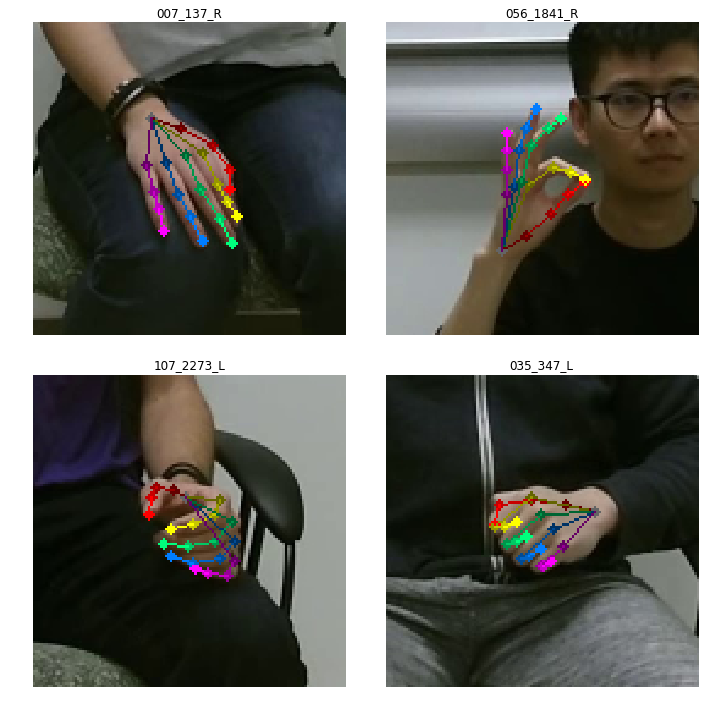

In [75]:
num = 4
fix, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = [a for b in ax for a in b] # wooooo


for i in range(len(data)):
    name, x, y = data[i]
    y = np.array(y.data, dtype=int).reshape(21,2)
    
    plt.tight_layout()
    ax[i].set_title(name)
    ax[i].axis('off')
    
    
    canvas = show.draw_hand(x, y)
    
    ax[i].imshow(canvas) 

    if i == num-1:
        plt.show()
        break

In [77]:
def train(model, loss_fn, optimizer, loader_train, loader_val=None, num_epochs=1):
    loss_history = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (name, x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            loss_history.append(float(loss))
            
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
#         model.eval()
        
#         for x, y in loader_train:
#             x_var = Variable(x.type(gpu_dtype), volatile=True)

#             scores = model(x_var)
#             _, preds = scores.data.cpu().max(1)
#             num_correct += (preds == y).sum()
#             num_samples += preds.size(0)
#         train_acc.append(float(num_correct) / num_samples)
        
#         for x, y in loader_val:
#             x_var = Variable(x.type(gpu_dtype), volatile=True)

#             scores = model(x_var)
#             _, preds = scores.data.cpu().max(1)
#             num_correct += (preds == y).sum()
#             num_samples += preds.size(0)
#         val_acc.append(float(num_correct) / num_samples)
        
    plt.subplot(1, 1, 1)
    plt.title('Training loss')
    plt.plot(solver.loss_history, 'o', alpha=.05)
    plt.xlabel('Iteration')

#     plt.subplot(2, 1, 2)
#     plt.title('Accuracy')
#     plt.plot(solver.train_acc_history, '-o', label='train')
#     plt.plot(solver.val_acc_history, '-o', label='val')
#     plt.plot([0.7] * len(solver.val_acc_history), 'k--')
#     plt.xlabel('Epoch')
#     plt.legend(loc='lower right')
    plt.gcf().set_size_inches(15, 12)
    plt.show()

In [91]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
#         self.conv1_drop = nn.Dropout2d(p=0.5)

        self.conv2 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
#         self.conv2_drop = nn.Dropout2d(p=0.5)

        self.conv3 = nn.Conv2d(30, 30, kernel_size=(1,1), stride=1, padding=1)
#         self.conv3_drop = nn.Dropout2d(p=0.5)

        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.bn2 = nn.BatchNorm2d(num_features=30)
        self.bn3 = nn.BatchNorm2d(num_features=30)

        self.pool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(8670, 2048)
#         self.fc1_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(2048, 2048)
#         self.fc2_drop = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(2048, 10)
    
    def forward(self, x):
        p = True
        if p: print("input",x.size())
        x = self.conv1(x)
        if p: print("conv1",x.size())
#         x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.bn1(x)
        if p: print("bn1",x.size())
        
        x = self.conv2(x)
        if p: print("conv2",x.size())
#         x = self.bn2(x)
        x = F.relu(x, inplace=True)
        x = self.bn2(x)
        if p: print("bn2",x.size())
        
        x = self.conv3(x)
        if p: print("conv3",x.size())
#         x = self.bn3(x)
        x = F.relu(x, inplace=True)
        x = self.bn3(x)
        if p: print("bn3",x.size())
        
        x = self.pool(x)
        if p: print("pool",x.size())
        
        N, C, H, W = x.size() 
        x =  x.view(N, -1)
        
        if p: print("Flattened",x.size())

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc1_drop(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc2_drop(x)

        x = self.fc3(x)
        x = F.relu(x)

        return x

In [92]:
gpu_dtype = torch.cuda.FloatTensor

model = Net().type(gpu_dtype)

loss_fn = nn.MSELoss().type(gpu_dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True, weight_decay=0.0)

train(model, loss_fn, optimizer, dataloader, num_epochs=1)
# check_accuracy(model, loader_test)

Starting epoch 1 / 1
input torch.Size([10, 128, 128, 3])
conv1 torch.Size([10, 128, 128, 3])
bn1 torch.Size([10, 128, 128, 3])
conv2 torch.Size([10, 128, 128, 3])


RuntimeError: running_mean should contain 128 elements not 30

In [9]:
def check_accuracy(model, loader):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [ ]:
scaled_joints = json.load(open("Dataset/scaled_annotations.json","r"))

In [ ]:
scaled_joints['065_401_R']

In [ ]:
v = torch.Tensor(scaled_joints['065_401_R']).view(-1)
v